In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Parâmetros do problema
num_clients = 495
max_access_points = 30
grid_size = 400  # Tamanho do centro de convenções
max_distance = 85  # Distância máxima entre cliente e ponto de acesso
access_point_capacity = 54  # Capacidade máxima de cada ponto de acesso em Mbps

In [29]:
# Função para ler dados do arquivo CSV e normalizar coordenadas
def read_and_normalize_data(csv_file):
    # Ler arquivo CSV
    df = pd.read_csv(csv_file, header=None, sep=',', names=['client_x', 'client_y', 'client_demand'])

    # Extrair coordenadas dos clientes
    client_coordinates = df[['client_x', 'client_y']].values
    
    # Normalizar coordenadas para a escala do grid_size
    client_coordinates = client_coordinates / df[['client_x', 'client_y']].max().max() * grid_size
    
    # Extrair consumo de banda dos clientes
    bandwidth_demands = df['client_demand'].values

    # # Normalizar consumo de banda para estar entre 0 e 1
    # bandwidth_demands = df['client_demand'].values / df['client_demand'].max()

    return client_coordinates, bandwidth_demands

In [30]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
print(client_coordinates)

[[ 36.53221975 141.44182441]
 [ 68.07031582  53.44402491]
 [  1.2008702   65.7097847 ]
 [171.32854892  68.63544297]
 [ 90.23330249 113.75559501]
 [ 21.83491286 131.86967068]
 [ 86.04936111  72.54332225]
 [  7.82586082  64.1604361 ]
 [109.14455753 126.70850941]
 [ 70.94296217 116.18614188]
 [ 82.11847666 104.43349754]
 [ 98.11407567 243.36475707]
 [122.71761146  81.60336076]
 [ 39.51989198  97.08584431]
 [  6.64899602  75.84006401]
 [ 74.82183491 110.84494011]
 [ 38.86274412  53.76209647]
 [101.27278638 130.41934435]
 [ 25.47373159 171.49858718]
 [122.95766547  84.28296367]
 [ 95.34145183  76.60123528]
 [ 24.42749619  51.8386637 ]
 [ 64.1524343   56.33367508]
 [121.91743142  10.35532995]
 [201.36530719  77.33139956]
 [ 62.46005351  35.94108674]
 [149.13355505 142.82213498]
 [ 36.97531945  87.81175765]
 [ 90.3653322   82.76562227]
 [ 69.64066915 149.96374184]
 [ 97.03483284  17.56895301]
 [ 55.10639894  96.50471356]
 [  8.93230977  27.1111    ]
 [ 66.47595709  47.84276462]
 [102.00295066

In [183]:
class Client:
    def __init__(self,id, x, y, banda):
        self.id = id
        self.x = x
        self.y = y
        self.banda = banda
        self.pa = None


In [295]:
import math

class PontoAcesso:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.capacidade = 54
        self.usuarios_conectados = []

    def try_connect_user(self, client: Client) -> bool:
        if self.capacidade < client.banda or self.__distance(client.x, client.y) > 85:
            return False

        self.capacidade = self.capacidade - client.banda
        self.usuarios_conectados.append(client)
        return True
        
    def is_active(self) -> bool:
        return len(self.usuarios_conectados) > 0
    
    def users_connected(self) -> int:
        return len(self.usuarios_conectados)

    def disconnect_user(self, client: Client) -> None:
        if client in self.usuarios_conectados:
            self.usuarios_conectados.remove(client)
            self.capacidade = self.capacidade + client.banda
            client.pa = None
    
    def __distance(self, x: float, y: float) -> float:
        return math.dist([x, y], [self.x, self.y])

    def __repr__(self):
        return f"PontoAcesso(x={self.x}, y={self.y}, capacidade={self.capacidade}, usuarios_conectados={self.usuarios_conectados})"


In [294]:
class Solution:

    def __init__(self, pas : dict, clients: list) -> None:
        self.pas = pas
        self.clients = clients

    
    def try_connect_user(self, id: str, client: Client) -> bool:
        print(self.pas[id])
        if self.pas[id].try_connect_user(client):
            self.clients[client.id].pa = id
            return True
        return False
    
    def disconnect_user(self, id: str, client: Client) -> bool:
        if self.pas[id].disconnect_user(client):
            self.clients[client.id].pa = None
            return True
        return False
    
    def active_access_point(self) -> int:
        counter = 0
        for key, value in self.pas.items():
            if value.is_active:
                counter += 1
        
        return counter
    
    def total_distance(self) -> float:
        total_distance = 0
        for key, value in self.pas.items():
            for client in value.usuarios_conectados:
                total_distance += math.dist([value.x, value.y], [client.x, client.y])
        return total_distance
    
    def is_valid_solution(self) -> bool:
        connected_users = [
            user
            for user in self.clients
            if user.pa is not None
        ]

        return (len(connected_users)/ num_clients) > 0.98

In [280]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
]

In [281]:
import random 

n = 30
sample_clients = random.sample(clients, n)
pas_dict = {}
for i in range(0, 30):
    pas_dict[str(i)] = PontoAcesso(str(i), sample_clients[i].x, sample_clients[i].y)

In [282]:
solution = Solution(pas_dict, clients)

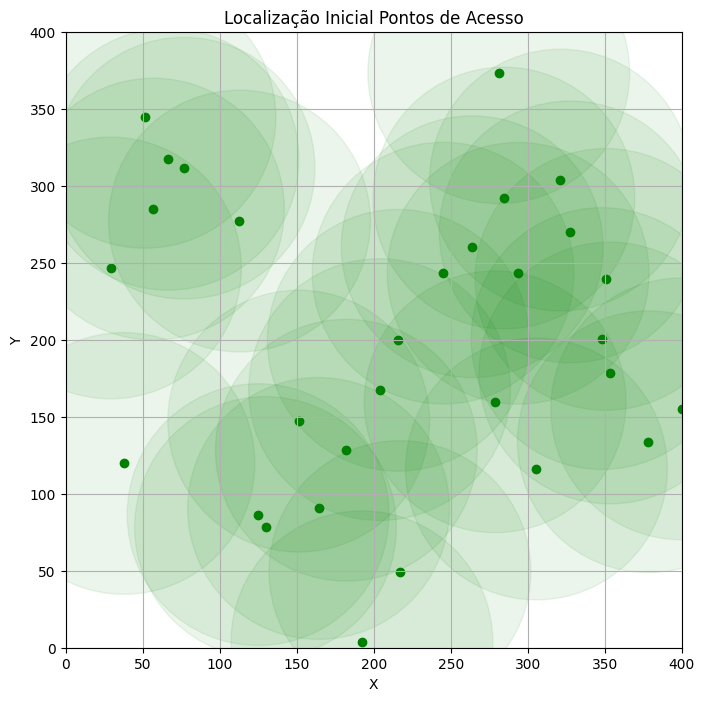

In [283]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in solution.pas.items():
    x, y = mapear_coordenadas(valor.x, valor.y)
    plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
    circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
    plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico
# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title('Localização Inicial Pontos de Acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [284]:
pas = pas_dict.copy()
def initial_solution() -> None:
    for client in solution.clients:
        counter = 0
        index = random.randrange(0, 29)
        while solution.try_connect_user(str(index), client) is not True:
            index = random.randrange(0, 29)
            counter += 1
            if counter >= 10:
                break


In [265]:
for client in solution.clients:
    print(client.pa)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [285]:
initial_solution()

PontoAcesso(x=327.59370858443145, y=130.00925208171836, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=164.2269510639894, y=309.56965317196364, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=37.84651546597985, y=280.3330749418619, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=182.2810132279763, y=271.7411417568953, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=164.2269510639894, y=309.56965317196364, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=151.33405016128629, y=252.83688829986747, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=217.08884499012277, y=350.5488734965367, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=112.88539921482332, y=122.92765872321272, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=281.2532819884474, y=26.62198994773824, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=203.85586757020326, y=232.37228376384684, capacidade=54, usuarios_conectados=[])
PontoAcesso(x=264.0194043659823, y=139.64141931934685, capa

In [286]:
def check_demand_coverage(solution: Solution):
    covered_clients = 0
    for key, value in solution.pas.items():
        covered_clients += value.users_connected()

    counter = 0
    for client in solution.clients:
        if client.pa is not None:
            counter += 1
    client_cvg_ratio = counter / num_clients
    coverage_ratio = covered_clients / num_clients
    return coverage_ratio

In [287]:
print(check_demand_coverage(solution))

0.8


In [3]:
# Ler dados do arquivo CSV e normalizar coordenadas
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
len(client_coordinates), len(bandwidth_demands)

(495, 495)

In [271]:
# Função objetivo 1: minimizar o número de pontos de acesso
def objective_function_1(solution: Solution):
    return solution.active_access_point()

# Função objetivo 2: minimizar a distância entre pontos de acesso e clientes
def objective_function_2(solution: Solution):
    return solution.total_distance()

In [296]:
objective_function_1(solution)

30

In [297]:
objective_function_2(solution)

20794.42905838545

In [292]:
import copy

# Explorar vizinhança (swap)
def explore_neighborhood_swap(solution: Solution):
    new_solution = solution.copy()
    i = random.randint(0, max_access_points - 1)
    disconnected_users = []
    for user_connected in new_solution.pas[str(i)].usuarios_conectados:
        new_solution.disconnect_user(str(i), user_connected)
        disconnected_users.append(user_connected)
    
    for user in disconnected_users:
        for pas in new_solution.pas.values():
            if new_solution.try_connect_user(pas.id, user):
                disconnected_users.remove(user)
                break

    return new_solution

# Explorar vizinhança (inserção)
def explore_neighborhood_insert(solution: Solution):
    new_solution = copy.deepcopy(solution)
    unatendent_clients = [
        client
        for client in new_solution.clients
        if client.pa is None
    ]
    
    selected_client = random.choice(unatendent_clients)
    selected_pa = random.choice(new_solution.pas.keys())

    new_solution.pas[selected_pa].x = selected_client.x
    new_solution.pas[selected_pa].y = selected_client.y

    for client in new_solution.pas[selected_pa].clients:
        new_solution.disconnect_user(selected_pa, client)
        unatendent_clients.append(client)

    for user in unatendent_clients:
        for pas in new_solution.pas.values():
            if new_solution.try_connect_user(pas.id, user):
                unatendent_clients.remove(user)
                break

    return new_solution

# Explorar vizinhança (reversão)
# def explore_neighborhood_reverse(solution: Solution):
#     new_solution = copy.deepcopy(solution)
#     i1, i2 = random.sample(range(max_access_points), 2)  # Seleciona dois índices aleatórios
#     new_solution['y'][i1], new_solution['y'][i2] = new_solution['y'][i2], new_solution['y'][i1]  # Troca os estados dos pontos de acesso
#     return new_solution

In [298]:
import copy

def shake(x: Solution, k: int):
    
    y = copy.deepcopy(x)
    
    if k == 1:             # apply not operator in one random position
        y = explore_neighborhood_insert(y)
        
    # elif k == 2:           # apply not operator in two random positions        
    #     y = explore_neighborhood_reverse(y)
        
    elif k == 2:           # apply not operator in three random positions
        y = explore_neighborhood_swap(y)      
    
    return y

In [300]:
# Função RVNS (Reactive Variable Neighborhood Search) generalizada
def rvns(max_iterations, max_iterations_no_improve, objective_function, neighborhood_function):
    # Inicializar solução aleatória
    clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
    ]   
    
    n = 30
    sample_clients = random.sample(clients, n)
    pas_dict = {}
    for i in range(0, 30):
        pas_dict[str(i)] = PontoAcesso(str(i), sample_clients[i].x, sample_clients[i].y)

    solution = Solution(pas_dict, clients)
    best_solution = copy.deepcopy(solution)
    best_fitness = objective_function(solution)

    iteration = 0
    k_max = 2
    while iteration < max_iterations:
        iteration += 1
        iteration_no_improve = 0
        k = 1

        while k <= k_max:
            iteration_no_improve += 1

            new_solution = shake(new_solution, k)
            # Explorar vizinhança
            new_solution, k = neighborhood_function(solution)

            # Avaliar a nova solução
            new_fitness = objective_function(new_solution)
            print(new_fitness)
            # Aceitar ou rejeitar a nova solução
            if (new_fitness < best_fitness) and check_demand_coverage(new_solution):
                best_solution = new_solution.copy()
                best_fitness = new_fitness
                iteration_no_improve = 0  # Resetar contador de iterações sem melhora

        # Atualizar solução com a melhor encontrada
        solution = copy.deepcopy(best_solution)

    return best_solution, best_fitness

In [9]:
# NÃO ESTÁ ENCONTRANDO RESULTADOS COERENTES PARA NENHUMA ESTRUTURA DE VIZINHANÇA, CONFERIR TUDO!

# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_swap)
#best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_swap)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'swap' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'swap' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.])}
Melh

In [9]:
# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_insert)
best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_insert)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'insert' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'insert' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}
Me

In [10]:
# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_reverse)
best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_reverse)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'reverse' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'reverse' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
M